In [216]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


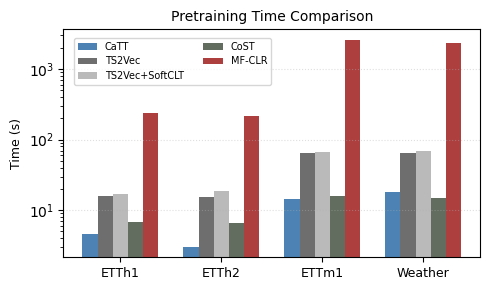

In [217]:
# Data and setup
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'Weather']
methods = ['CaTT', 'TS2Vec', 'TS2Vec+SoftCLT', 'CoST', 'MF-CLR']
data = np.array([
    [4.62, 16.12, 16.93, 6.70, 239.33],
    [3.02, 15.63, 18.50, 6.69, 216.32],
    [14.43, 65.37, 66.11, 15.80, 2604.35],
    [18.05, 63.95, 68.12, 14.89, 2332.83]
])

# Compact plot
plt.figure(figsize=(5, 3))
bar_width = 0.15
index = np.arange(len(datasets))
colors = ['#1F64A1', '#4A4A4A','#A9A9A9', '#3B4937', '#990F0F']

for i, method in enumerate(methods):
    plt.bar(index + i*bar_width, data[:, i], width=bar_width, 
            label=method, color=colors[i], alpha=0.8)

plt.xticks(index + 2*bar_width, datasets, fontsize=9)
plt.ylabel('Time (s)', fontsize=9)
plt.yscale('log')  # Log scale for better visibility
plt.title('Pretraining Time Comparison', fontsize=10)
plt.legend(fontsize=7, ncol=2, bbox_to_anchor=(0.51, 0.985))
plt.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

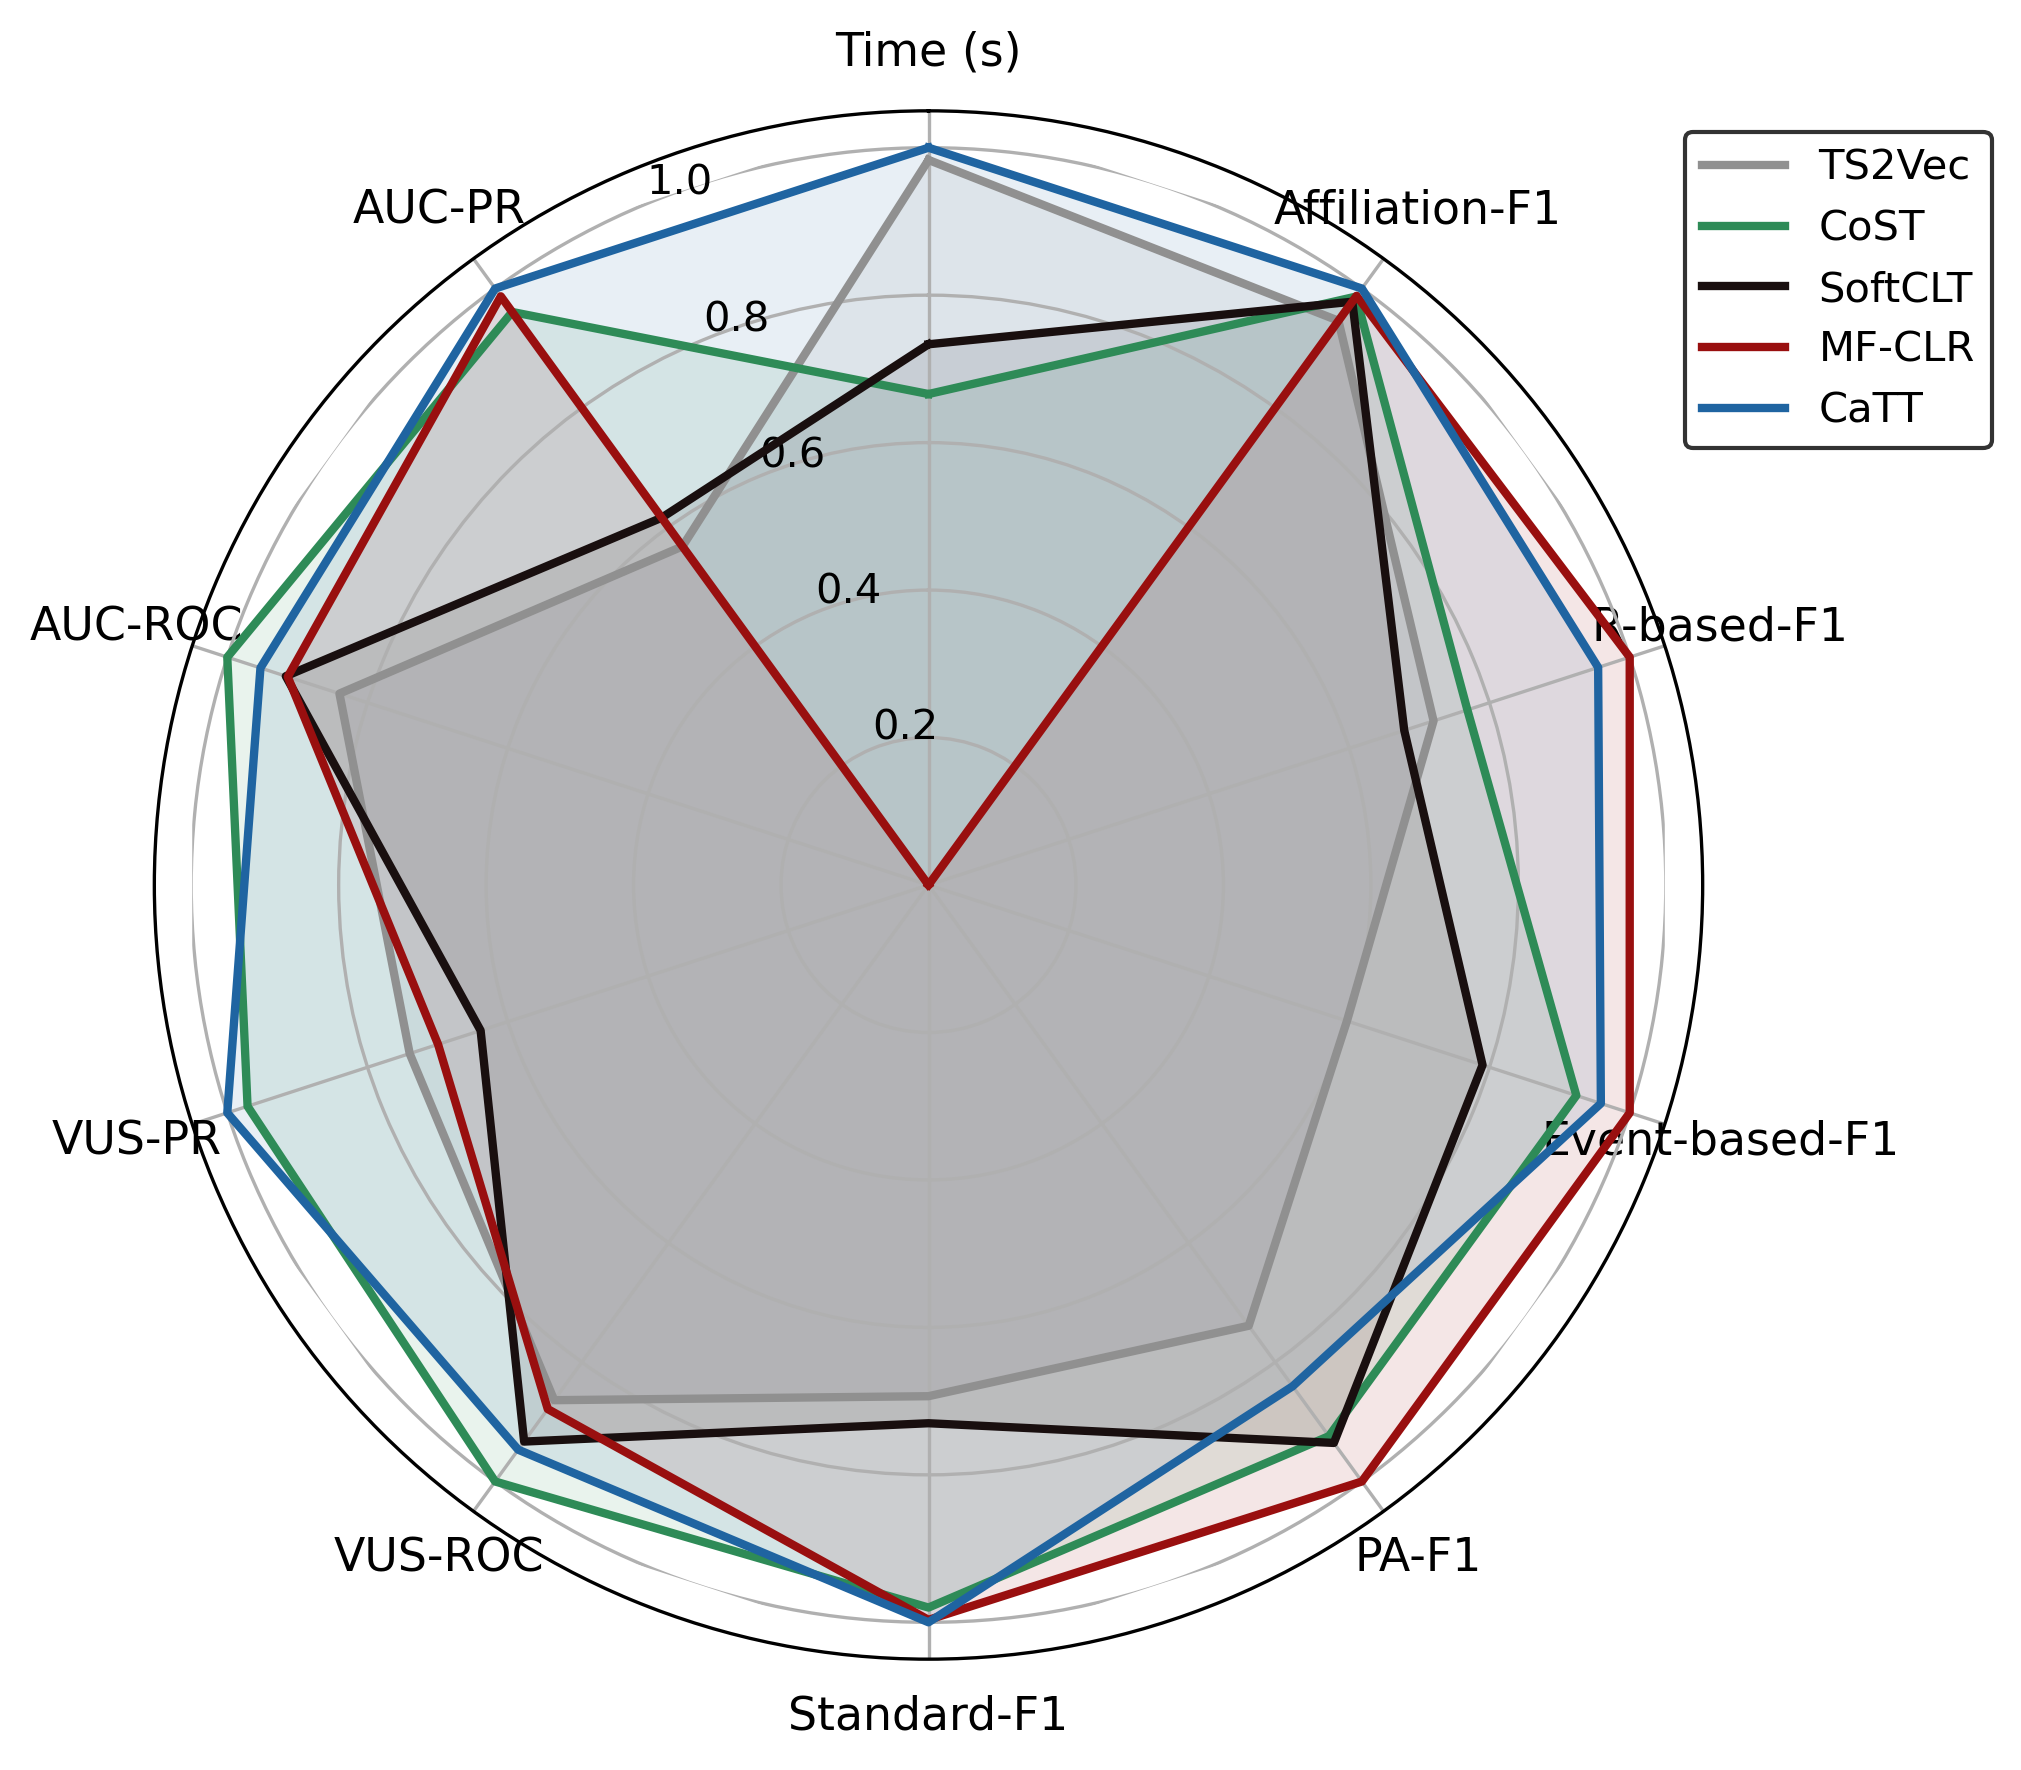

In [218]:
# Data
metrics = ['Time (s)', 'AUC-PR', 'AUC-ROC', 'VUS-PR', 'VUS-ROC',
           'Standard-F1', 'PA-F1', 'Event-based-F1', 'R-based-F1', 'Affiliation-F1']
methods = ['TS2Vec', 'CoST', 'SoftCLT', 'MF-CLR', 'CaTT']
data = {
    'CaTT': [128.44, 0.229, 0.685, 0.346, 0.764, 0.300, 0.663, 0.466, 0.297, 0.814],
    'TS2Vec': [137.11, 0.130, 0.604, 0.256, 0.697, 0.208, 0.583, 0.290, 0.224, 0.770],
    'CoST':   [476.65, 0.220, 0.719, 0.336, 0.807, 0.294, 0.729, 0.449, 0.239, 0.803],
    'SoftCLT':[365.76, 0.141, 0.659, 0.221, 0.753, 0.219, 0.738, 0.384, 0.211, 0.796],
    'MF-CLR':[6505.80,0.226, 0.657, 0.242, 0.709, 0.299, 0.789, 0.486, 0.311, 0.804]
}

# Log-normalize time
times = np.array([data[m][0] for m in methods])
log_times = np.log10(times)
log_max, log_min = np.max(log_times), np.min(log_times)
norm_log_times = (log_max - log_times) / (log_max - log_min)  # invert: lower time = better

# Normalize all metrics
normalized_data = {}
for idx, method in enumerate(methods):
    norm_vals = []
    for i in range(len(metrics)):
        if i == 0:  # Time
            norm_val = norm_log_times[idx]
        else:
            col_vals = [data[m][i] for m in methods]
            norm_val = data[method][i] / max(col_vals)
        norm_vals.append(norm_val)
    norm_vals.append(norm_vals[0])  # Wrap
    normalized_data[method] = norm_vals

# Radar chart factory
def radar_factory(num_vars, frame='polygon'):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(*args, closed=closed, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1] or y[0] != y[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=11)

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown frame: %s" % frame)

    register_projection(RadarAxes)
    return np.concatenate((theta, [theta[0]]))  # Wrap theta

# Plot
fig = plt.figure(figsize=(7, 6), dpi=300)
theta = radar_factory(len(metrics), frame='polygon')
ax = fig.add_subplot(111, projection='radar')

colors = ['#909090', '#2E8B57', '#190F0F', '#990F0F', '#1F64A1']
# colors = ['#B0B0B0', '#7A7A7A', '#4C4C4C', '#686868', '#949494']

for idx, method in enumerate(methods):
    ax.plot(theta, normalized_data[method], color=colors[idx], label=method, linewidth=2)
    ax.fill(theta, normalized_data[method], facecolor=colors[idx], alpha=0.1)

ax.set_varlabels(metrics)
ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fontsize=10)
legend.get_frame().set_linewidth(1.0)
legend.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.savefig("anomaly_radar_plot_log_normalized.png", dpi=300)
plt.show()